In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Tensor

In [2]:
torch.HalfTensor      # 16 бит, с плавающей точкой
torch.FloatTensor     # 32 бита,  с плавающей точкой
torch.DoubleTensor    # 64 бита, с плавающей точкой

torch.ShortTensor     # 16 бит, целочисленный, знаковый
torch.IntTensor       # 32 бита, целочисленный, знаковый
torch.LongTensor      # 64 бита, целочисленный, знаковый

torch.CharTensor      # 8 бит, целочисленный, знаковый
torch.ByteTensor      # 8 бит, целочисленный, беззнаковый

torch.ByteTensor

In [3]:
a = torch.FloatTensor([1.0])
b = torch.DoubleTensor([2.0])
a * b

tensor([2.], dtype=torch.float64)

In [4]:
x = torch.FloatTensor([[-3], [8]])
w = torch.FloatTensor([[1, 1], [1, 1]])
b = torch.FloatTensor([[1], [1]])
y = torch.add(torch.matmul(w, x), b)
print(y)

tensor([[6.],
        [6.]])


# Нейронная сеть

Загружаем набор данных

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Визуализируем несколько снимков из набора

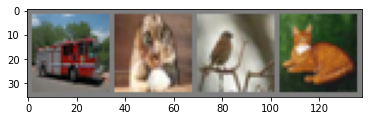

truck cat   bird  cat  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Создаём модель

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Выбираем функцию потерь и оптимизатор для обучения и создаём для них объекты

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Обучаем модель

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.158
[1,  4000] loss: 1.789
[1,  6000] loss: 1.631
[1,  8000] loss: 1.573
[1, 10000] loss: 1.515
[1, 12000] loss: 1.446
[2,  2000] loss: 1.386
[2,  4000] loss: 1.368
[2,  6000] loss: 1.376
[2,  8000] loss: 1.319
[2, 10000] loss: 1.311
[2, 12000] loss: 1.288
Finished Training


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %
